Eq. (8.141), with $q_i=1$:

$$
    \dfrac{P}{P_0} = 1 + \dfrac{6\pi\epsilon_0}{\lvert\mathbf{p}\rvert^2} \dfrac{1}{k^3} \operatorname{Im}\left\{ \mathbf{p}^{\ast} \cdot \mathbf{E}_{ref} (\mathbf{r}_0) \right\}
$$

Eq. (10.25):

$$
 \overleftrightarrow{\mathbf{G}}_{ref}(\mathbf{r}_0, \mathbf{r}_0) = \dfrac{i}{8\pi k_1^2} \int_0^{\infty} \dfrac{k_{\rho}}{k_{z_1}} \left[\begin{matrix} k_1^2 r^s - k_{z_1}^2 r^p & 0 & 0\\ 0 & k_1^2 r^s - k_{z_1}^2 r^p & 0\\ 0 & 0 & 2k_{\rho}^2 r^p\end{matrix} \right] e^{2ik_{z_1}z_0} dk_{\rho}
$$

From (10.23):

$$
    \mathbf{E}_{ref} (\mathbf{r}_0) = \omega^2\mu_0\mu_1 \overleftrightarrow{\mathbf{G}}_{ref}(\mathbf{r}_0, \mathbf{r}_0) \cdot \mathbf{p}
$$

Therefore, inserting (10.23) into (8.141) means to solve the product (assuming $\mu_1 \simeq 1$):

$$
    \mathbf{p}^{\ast} \cdot \mathbf{E}_{ref} (\mathbf{r}_0) = \mathbf{p}^{\ast} \cdot \omega^2\mu_0 \overleftrightarrow{\mathbf{G}}_{ref}(\mathbf{r}_0, \mathbf{r}_0) \mathbf{p} =
$$

and finally inserting the (very long) eq. (10.25):

$$
    = \dfrac{\omega^2\mu_0 i}{8\pi k_1^2} \int_0^{\infty} \dfrac{k_{\rho}}{k_{z_1}} \mathbf{p}^{\ast} \cdot \overleftrightarrow{\mathbf{M}} \cdot \mathbf{p} ~ e^{2ik_{z_1}z_0} dk_{\rho}
$$

where $\overleftrightarrow{\mathbf{M}}$ is the inner matrix.

We end up solving the following matrix product:

$$
    \mathbf{p}^{\ast} \cdot \overleftrightarrow{\mathbf{M}} \cdot \mathbf{p} = \left[\begin{matrix} p_x & p_y & p_z\end{matrix} \right] \left[\begin{matrix} M_1 & 0 & 0\\ 0 & M_1 & 0\\ 0 & 0 & M_2\end{matrix} \right] \left[\begin{matrix} p_x \\ p_y \\ p_z\end{matrix} \right]
$$

In the end we get:

$$
    = \dfrac{\omega^2\mu_0 i}{8\pi k_1^2} \int_0^{\infty} \dfrac{k_{\rho}}{k_{z_1}} (p_x^2 + p_y^2) (k_1^2 r^s - k_{z_1}^2 r^p) ~ e^{2ik_{z_1}z_0} dk_{\rho} + \dfrac{\omega^2\mu_0 i}{8\pi k_1^2} \int_0^{\infty} \dfrac{k_{\rho}}{k_{z_1}} p_z^2 2k_{\rho}^2 r^p ~ e^{2ik_{z_1}z_0} dk_{\rho}
$$

We can try to make our life easier (not so sure how much tho...) with the following substitutions:

$$ s = k_{\rho} / k_{1} \qquad \qquad \qquad \qquad \qquad \rightarrow \qquad ds = 1/k_1 dk_{\rho} $$

$$ s_z = s_z(s) = \sqrt{1-s^2} = k_{z_{1}}/k_{1} $$

so to have:

$$
    = \dfrac{\omega^2\mu_0 i}{8\pi} (p_x^2 + p_y^2) \int_0^{\infty} \dfrac{s}{k_{z_1}/k_1^2} (r^s - s_z^2 r^p) ~ e^{2ik_1z_0s_z} ds + \dfrac{\omega^2\mu_0 i}{8\pi} 2p_z^2 \int_0^{\infty}  k_1 \dfrac{s^3}{s_z} r^p ~ e^{2ik_1z_0s_z} ds
$$

Final effort! Plug what we just obtained in (8.141) and [play](https://open.spotify.com/track/7iAqvWLgZzXvH38lA06QZg):

$$
    \dfrac{P}{P_0} = 1 + \dfrac{6\pi\epsilon_0}{\lvert\mathbf{p}\rvert^2} \dfrac{1}{k_1^3} \operatorname{Im}\left\{ \dfrac{\omega^2\mu_0 i}{8\pi} (p_x^2 + p_y^2) \int_0^{\infty} \dfrac{s}{k_{z_1}/k_1^2} (r^s - s_z^2 r^p) ~ e^{2ik_1z_0s_z} ds \right\}
$$

$$
     + \dfrac{6\pi\epsilon_0}{\lvert\mathbf{p}\rvert^2} \dfrac{1}{k_1^3} \operatorname{Im}\left\{ \dfrac{\omega^2\mu_0 i}{8\pi} 2p_z^2 \int_0^{\infty}  k_1 \dfrac{s^3}{s_z} r^p ~ e^{2ik_1z_0s_z} ds \right\} =
$$

$$
    = 1 + \dfrac{(p_x^2 + p_y^2)}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{4}  \dfrac{\epsilon_0\mu_0\omega^2}{k^2}\operatorname{Im}\left\{ i \int_0^{\infty} \dfrac{s}{s_{z}} (r^s - s_z^2 r^p) ~ e^{2ik_1z_0s_z} ds \right\} + \dfrac{p_z^2}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{2} \dfrac{\epsilon_0\mu_0\omega^2}{k^2}  \operatorname{Im}\left\{ i \int_0^{\infty} \dfrac{s^3}{s_z} r^p ~ e^{2ik_1z_0s_z} ds \right\}
$$

And finally considering that:

$$ \epsilon_0\mu_0\omega^2 = k^2 $$

and that holds the relation:

$$ \operatorname{Im}\left\{ i \cdot n \right\} \qquad\qquad\rightarrow \qquad\qquad \operatorname{Re}\left\{ n \right\} $$

we finally get (10.26):

$$\dfrac{P}{P_0}(z_0) = 1 + \dfrac{p_x^2 + p_y^2}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{4} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s}{s_z} \left[r^s - s_z^2 r^p\right] e^{2 i k_1 z_0 s_z} \right\}ds + \dfrac{p_z^2}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{2} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s^3}{s_z} r^p e^{2ik_1z_0s_z} \right\}ds $$

Reminder:

$$ k_{z_1} = \sqrt{k_1^2 - (k_x^2 + k_y^2)}  \newline k_{z_2} = \sqrt{k_2^2 - k_{\rho}^2}, \qquad\qquad\qquad\qquad\text{w.      }\quad k_{\rho}^2 = k_{x_2}^2 + k_{y_2}^2 $$

Given the following geometry:
<div>
<img src="assets/geometry.png" width="500"/>
</div>

The dipole can be written as:

$$ p_x = \lvert\mathbf{p}\rvert \sin(\theta) \cos(\phi) \newline $$
$$ p_y = \lvert\mathbf{p}\rvert \sin(\theta) \sin(\phi) \newline $$
$$ p_z = \lvert\mathbf{p}\rvert \cos(\theta) \newline $$

so to simplify the main equation to:

$$\dfrac{P}{P_0}(z_0) = 1 + \sin^2(\theta) \dfrac{3}{4} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s}{s_z} \left[r^s - s_z^2 r^p\right] e^{2 i k_1 z_0 s_z} \right\}ds + \cos^2(\theta) \dfrac{3}{2} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s^3}{s_z} r^p e^{2ik_1z_0s_z} \right\}ds $$

For the integration we have:

$$\dfrac{P}{P_0}_{tot}(z_0) = 1 + f(\theta) \int_0^{1} I(s) ds + g(\theta) \int_0^{1} J(s) ds + f(\theta) \int_1^{\infty} I(s) ds + g(\theta) \int_1^{\infty} J(s) ds = \dfrac{P}{P_0}_{rad} + \dfrac{P}{P_0}_{non~rad}$$

**Fresnel Coefficients**

$$ r^s = \dfrac{k_{z_1} - k_{z_2}}{k_{z_1} + k_{z_2}} \\[10pt] r^p = \dfrac{\epsilon_2 k_{z_1} - \epsilon_1 k_{z_2}}{\epsilon_2 k_{z_1} + \epsilon_1 k_{z_2}} $$

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
e1 = 1
wl = 488e-9  # m

In [6]:
class InteractiveLegend(object):
    """Interactive legend for position analysis plots. 
    Allows to show/hide spectra lines in plot by clicking on the corresponding
    occurrency in the æegend.
    Right-click with the mouse for hiding all lines.

    Args:
        object (_type_): _description_
    """
    def __init__(self, legend=None, ax = None):
        if legend == None:
            if ax == None:
                legend = plt.gca().get_legend()
            else:
                legend = ax.get_legend()
            # legend.set_draggable(state=True)
        self.legend = legend
        self.fig = legend.axes.figure
        self.lookup_artist, self.lookup_handle = self._build_lookups(legend)
        self._setup_connections()
        self.update()
    def _setup_connections(self):
        for artist in self.legend.texts + self.legend.legend_handles:
            artist.set_picker(10) # 10 points tolerance
        self.fig.canvas.mpl_connect('pick_event', self.on_pick)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
    def _build_lookups(self, legend):
        labels = [t.get_text() for t in legend.texts]
        handles = legend.legend_handles
        label2handle = dict(zip(labels, handles))
        handle2text = dict(zip(handles, legend.texts))
        lookup_artist = {}
        lookup_handle = {}
        for artist in legend.axes.get_children():
            if artist.get_label() in labels:
                handle = label2handle[artist.get_label()]
                lookup_handle[artist] = handle
                lookup_artist[handle] = artist
                lookup_artist[handle2text[handle]] = artist
        lookup_handle.update(zip(handles, handles))
        lookup_handle.update(zip(legend.texts, handles))
        return lookup_artist, lookup_handle
    def on_pick(self, event):
        handle = event.artist
        if handle in self.lookup_artist:
            artist = self.lookup_artist[handle]
            artist.set_visible(not artist.get_visible())
            self.update()
    def on_click(self, event):
        if event.button == 3:
            visible = False
        elif event.button == 2:
            visible = True
        else:
            return
        for artist in self.lookup_artist.values():
            artist.set_visible(visible)
        self.update()
    def update(self):
        for artist in self.lookup_artist.values():
            handle = self.lookup_handle[artist]
            if artist.get_visible():
                handle.set_visible(True)
            else:
                handle.set_visible(False)
        self.fig.canvas.draw()


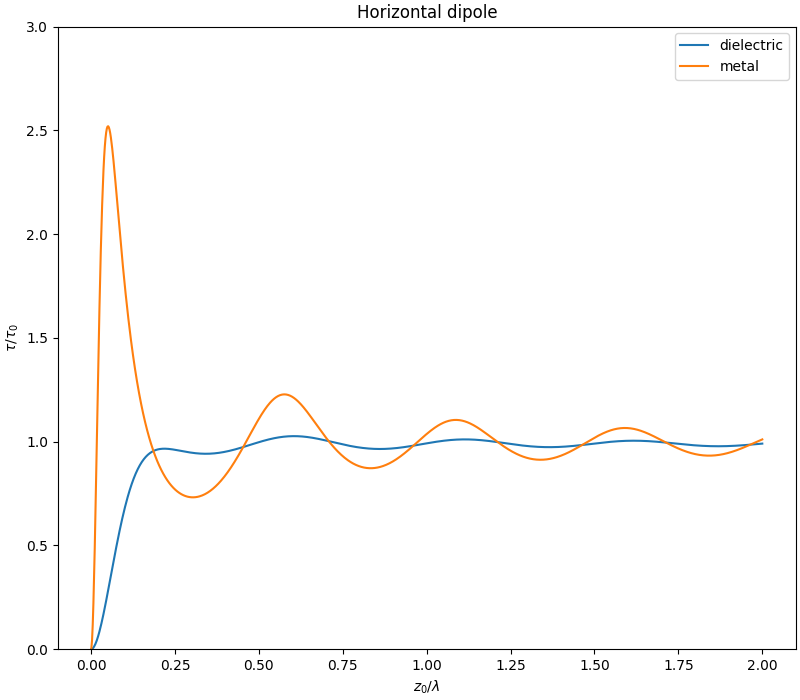

In [16]:
def calculate_gamma(eps1,eps2,wl,z0,theta,n1=10000,n2=10000):
    #Calculate the k magnitude
    k1 = 2*np.pi/wl*np.sqrt(eps1)
    k2 = 2*np.pi/wl*np.sqrt(eps2)

    #Define s and sz for gamma r
    s = np.linspace(0,1,n1)
    s = s[1:-1]
    sz = np.sqrt(1-s**2)

    #Calculate the projection of k on z
    k1z = sz*k1
    krho = s*k1
    k2z = np.sqrt(k2**2-krho)
    #Calculate the reflection coefficient
    rs = (k1z-k2z)/(k1z+k2z)
    rp = (eps2*k1z-eps1*k2z)/(eps2*k1z+eps1*k2z)

    radiative = 1
    radiative += np.sin(theta)**2*3/4 *integrate.simps(y=np.real(s/sz*(rs-sz**2*rp)*np.exp(2*1j*k1*z0*sz)),x=s)
    radiative += np.cos(theta)**2*3/2 *integrate.simps(y=np.real(s**3/sz*rp*np.exp(2*1j*k1*z0*sz)),x=s)

    #Define s and sz for gamma nr
    n = 10
    s = np.linspace(1,np.sqrt(n**2/4/k1**2/z0**2+1),n2)
    s = s[1:-1]
    sz = 1j*np.sqrt(s**2-1)

    #Calculate the projection of k on z
    k1z = sz*k1
    krho = s*k1
    k2z = np.sqrt(k2**2-krho)
    #Calculate the reflection coefficient
    rs = (k1z-k2z)/(k1z+k2z)
    rp = (eps2*k1z-eps1*k2z)/(eps2*k1z+eps1*k2z)

    nonradiative = np.sin(theta)**2*3/4 *integrate.simps(y=np.real(s/sz*(rs-sz**2*rp)*np.exp(2*1j*k1*z0*sz)),x=s)
    nonradiative += np.cos(theta)**2*3/2 *integrate.simps(y=np.real(s**3/sz*rp*np.exp(2*1j*k1*z0*sz)),x=s)

    return radiative,nonradiative


# =============================================================================
# Horizontal dipole
# =============================================================================

e2d = 2.25
e2m = -34.5+8.5*1j
theta=np.pi/2

fig, ax = plt.subplots(figsize=(8,7), layout='constrained') # (width, height) in inches

norm_height = np.linspace(0.001, 2, 1000)

gamma_radd = np.zeros(norm_height.shape)
gamma_nonradd = np.zeros(norm_height.shape)
gamma_radm = np.zeros(norm_height.shape)
gamma_nonradm = np.zeros(norm_height.shape)
for i,z0 in enumerate(norm_height*wl):
    radd, nonradd = calculate_gamma(e1,e2d,wl,z0,theta)
    radm, nonradm = calculate_gamma(e1,e2m,wl,z0,theta)

    gamma_radd[i] = radd
    gamma_nonradd[i] = nonradd
    gamma_radm[i] = radm
    gamma_nonradm[i] = nonradm

ax.set_title("Horizontal dipole")
# ax.plot(norm_height,gamma_rad, label=r"$\tau/\tau_0 (rad)$")
# ax.plot(norm_height,gamma_nonrad, label=r"$\tau/\tau_0 (non rad)$")
ax.plot(norm_height,1/(gamma_radd+gamma_nonradd), label=r"dielectric")
ax.plot(norm_height,1/(gamma_radm+gamma_nonradm), label=r"metal")
ax.set_ylim(0,3)
ax.set_ylabel(r"$\tau/\tau_0$")
ax.set_xlabel(r"$z_0/\lambda$")
l = ax.legend(loc='upper right', fancybox=True)

plt.show()

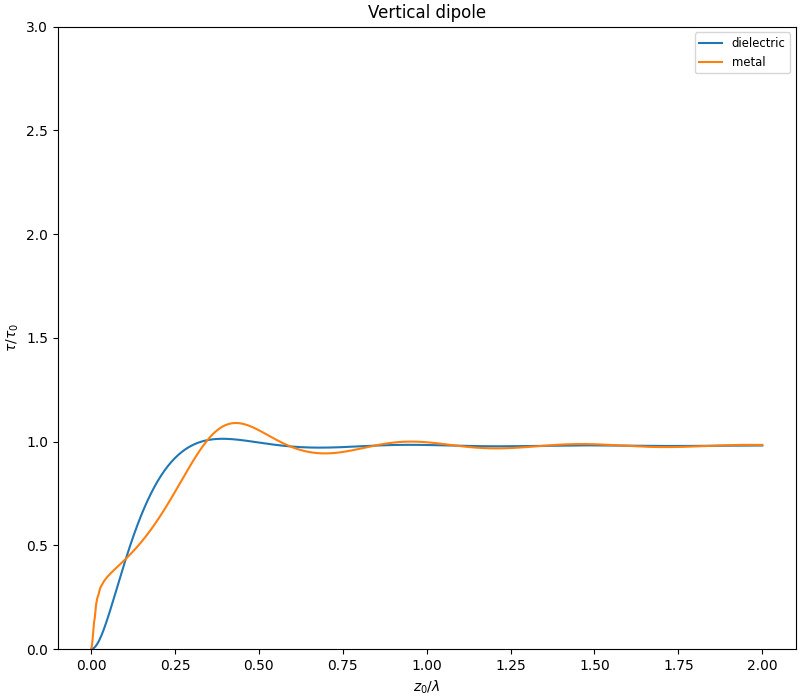

In [18]:
# =============================================================================
# Vertical dipole
# =============================================================================

e2d = 2.25
e2m = -34.5+8.5*1j
theta=0

fig, ax = plt.subplots(figsize=(8,7), layout='constrained') # (width, height) in inches

norm_height = np.linspace(0.001, 2, 1000)

gamma_radd = np.zeros(norm_height.shape)
gamma_nonradd = np.zeros(norm_height.shape)
gamma_radm = np.zeros(norm_height.shape)
gamma_nonradm = np.zeros(norm_height.shape)
for i,z0 in enumerate(norm_height*wl):
    radd, nonradd = calculate_gamma(e1,e2d,wl,z0,theta)
    radm, nonradm = calculate_gamma(e1,e2m,wl,z0,theta)

    gamma_radd[i] = radd
    gamma_nonradd[i] = nonradd
    gamma_radm[i] = radm
    gamma_nonradm[i] = nonradm

ax.set_title("Vertical dipole")
# ax.plot(norm_height,gamma_rad, label=r"$\tau/\tau_0 (rad)$")
# ax.plot(norm_height,gamma_nonrad, label=r"$\tau/\tau_0 (non rad)$")
ax.plot(norm_height,1/(gamma_radd+gamma_nonradd), label=r"dielectric")
ax.plot(norm_height,1/(gamma_radm+gamma_nonradm), label=r"metal")
ax.set_ylim(0,3)
ax.set_ylabel(r"$\tau/\tau_0$")
ax.set_xlabel(r"$z_0/\lambda$")
l = ax.legend(loc='upper right', fancybox=True, fontsize='small')

plt.show()